<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/07_pytorch_experiment_tracking_exercise_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. PyTorch Experiment Tracking Exercise Template

Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

We'll need to make sure we have `torch` v.1.12+ and `torchvision` v0.13+.

In [ ]:
# # For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0.dev20220622+cu113
torchvision version: 0.14.0.dev20220622+cu113


In [3]:
import torch
import torchvision
# Make sure we have a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Get regular imports 
import matplotlib.pyplot as plt
import torch
import torchvision


from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [7]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [8]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs\2025-07-22\test_experiment_name\this_is_the_model_name\add_a_little_extra_if_you_want...


In [10]:
from typing import Dict, List
from tqdm.auto import tqdm

from engine import train_step, test_step

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [11]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [37]:
data_20_percent_path

WindowsPath('data/pizza_steak_sushi_20_percent')

In [12]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [13]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# Create a transform pipeline
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(), # get image values between 0 & 1
                                       normalize
])

### Turn data into DataLoaders 

In [14]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?
* **Hint:** You'll need to set up an exerpiment similar to [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code).

In notebook 07, we tried out EffNetB0 and EffNetB2 with 4M and 9M params respectively. Let's try step things up by using a bigger model.

Let's try EfficientNet_V2_S (efficientnet version 2 small) which has ~20M params

To keep simple let's just compare EffNetb2 (best performing model) to EffNetV2_S

In [17]:
import torchvision.models  as models

weights = models.EfficientNet_V2_S_Weights.DEFAULT
effnetv2 = models.efficientnet_v2_s(weights=weights).to(device)


    

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\yashs/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|█████████████████████████████████████████████████████████████████████████████| 82.7M/82.7M [00:06<00:00, 12.8MB/s]


In [18]:
summary(effnetv2, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         48
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         5,232
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         5,232
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                         

### Create models

In [19]:

def create_model(model_name: str, out_features=len(class_names)):
    assert model_name in ['effnetb2', 'effnetv2_s'], 'model_name should be effnetb2 or effnetv2s'  
    if model_name == 'effnetb2':
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
        model = torchvision.models.efficientnet_b2(weights=weights)
        dropout = 0.3
        in_features=1408
    else:
        weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        model = torchvision.models.efficientnet_v2_s(weights=weights)
        dropout = 0.2
        in_features=1280

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change classifier head 
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features, out_features=out_features)
    )

    # Set the model name
    model.name = model_name 
    print(f'[INFO] Creating {model.name} feature extractor model')
    return model
    

In [24]:
effnetv2_s = create_model(model_name='effnetv2_s')
#effnetb2

[INFO] Creating effnetv2_s feature extractor model


### Setup modelling experiments


In [26]:
# Create epoch list
num_epochs =[5, 10]

# Create models list
models = ['effnetb2', 'effnetv2_s']

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [27]:
from utils import save_model

In [30]:
%%time 

# 1. set the random seeds
set_seeds()

# 2. Keep track of experiment number 
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            model = create_model(model_name=model_name) # instantiate a new model instance
            model.to(device)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments 
            train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs=epochs,
                 device=device,
                 writer=create_writer(experiment_name=dataloader_name,
                                     model_name=model_name,
                                     extra=f'{epochs}_epochs'))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetb2 feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9872 | train_acc: 0.5352 | test_loss: 0.9599 | test_acc: 0.6506
Epoch: 2 | train_loss: 0.8184 | train_acc: 0.7227 | test_loss: 0.8650 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.7786 | train_acc: 0.6367 | test_loss: 0.8038 | test_acc: 0.7652
Epoch: 4 | train_loss: 0.6811 | train_acc: 0.7344 | test_loss: 0.6943 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5711 | train_acc: 0.9141 | test_loss: 0.6968 | test_acc: 0.8466
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_10_percent\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0711 | train_acc: 0.5195 | test_loss: 0.9545 | test_acc: 0.6922
Epoch: 2 | train_loss: 0.8927 | train_acc: 0.7969 | test_loss: 0.8515 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7824 | train_acc: 0.8164 | test_loss: 0.7415 | test_acc: 0.7746
Epoch: 4 | train_loss: 0.7113 | train_acc: 0.8438 | test_loss: 0.6517 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6872 | train_acc: 0.7383 | test_loss: 0.5885 | test_acc: 0.9167
[INFO] Saving model to: models\07_effnetv2_s_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Creating effnetb2 feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_10_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0603 | train_acc: 0.4102 | test_loss: 0.9665 | test_acc: 0.6723
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.5273 | test_loss: 0.8835 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8204 | train_acc: 0.6641 | test_loss: 0.7278 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.7015 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.6150 | train_acc: 0.9180 | test_loss: 0.6837 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.5602 | train_acc: 0.9062 | test_loss: 0.6584 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.6199 | train_acc: 0.7695 | test_loss: 0.6224 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.5163 | train_acc: 0.9180 | test_loss: 0.5637 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.4952 | train_acc: 0.8242 | test_loss: 0.5386 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5033 | train_acc: 0.8086 | test_loss: 0.5183 | test_acc: 0.9186
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0322 | train_acc: 0.5781 | test_loss: 0.9684 | test_acc: 0.6326
Epoch: 2 | train_loss: 0.9218 | train_acc: 0.5820 | test_loss: 0.8426 | test_acc: 0.7140
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7383 | test_loss: 0.7553 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7136 | train_acc: 0.7852 | test_loss: 0.6440 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6584 | train_acc: 0.7344 | test_loss: 0.6318 | test_acc: 0.8144
Epoch: 6 | train_loss: 0.6296 | train_acc: 0.7656 | test_loss: 0.6148 | test_acc: 0.8144
Epoch: 7 | train_loss: 0.5666 | train_acc: 0.8047 | test_loss: 0.5418 | test_acc: 0.8456
Epoch: 8 | train_loss: 0.5573 | train_acc: 0.7617 | test_loss: 0.5584 | test_acc: 0.8153
Epoch: 9 | train_loss: 0.5061 | train_acc: 0.8047 | test_loss: 0.5283 | test_acc: 0.8248
Epoch: 10 | train_loss: 0.5163 | train_acc: 0.7852 | test_loss: 0.5248 | test_acc: 0.8456
[INFO] Saving model to: models\07_effnetv2_s_data_10_percent_10_epochs.pth
----------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9795 | train_acc: 0.5771 | test_loss: 0.7806 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7311 | train_acc: 0.7562 | test_loss: 0.6943 | test_acc: 0.8466
Epoch: 3 | train_loss: 0.6042 | train_acc: 0.8438 | test_loss: 0.5661 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5506 | train_acc: 0.8729 | test_loss: 0.5409 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.5095 | train_acc: 0.8521 | test_loss: 0.5369 | test_acc: 0.8769
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_20_percent\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5938 | test_loss: 0.7793 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7483 | train_acc: 0.7750 | test_loss: 0.5994 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6456 | train_acc: 0.8021 | test_loss: 0.5266 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.5307 | train_acc: 0.8708 | test_loss: 0.4748 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.5103 | train_acc: 0.8604 | test_loss: 0.4220 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Creating effnetb2 feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_20_percent\effnetb2\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0456 | train_acc: 0.4750 | test_loss: 0.8732 | test_acc: 0.7746
Epoch: 2 | train_loss: 0.7987 | train_acc: 0.7729 | test_loss: 0.7285 | test_acc: 0.8665
Epoch: 3 | train_loss: 0.6604 | train_acc: 0.8375 | test_loss: 0.6345 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.6185 | train_acc: 0.8021 | test_loss: 0.5732 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4706 | train_acc: 0.8938 | test_loss: 0.5271 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.4422 | train_acc: 0.8896 | test_loss: 0.5188 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.4169 | train_acc: 0.8833 | test_loss: 0.4252 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3903 | train_acc: 0.8875 | test_loss: 0.4772 | test_acc: 0.8570
Epoch: 9 | train_loss: 0.3766 | train_acc: 0.8812 | test_loss: 0.4170 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.3011 | train_acc: 0.9333 | test_loss: 0.3999 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9686 | train_acc: 0.5979 | test_loss: 0.7846 | test_acc: 0.7955
Epoch: 2 | train_loss: 0.6988 | train_acc: 0.7979 | test_loss: 0.6245 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5973 | train_acc: 0.8521 | test_loss: 0.5488 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4993 | train_acc: 0.8708 | test_loss: 0.5002 | test_acc: 0.8674
Epoch: 5 | train_loss: 0.5190 | train_acc: 0.8146 | test_loss: 0.4466 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4432 | train_acc: 0.8917 | test_loss: 0.4203 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.4195 | train_acc: 0.8854 | test_loss: 0.4009 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.4267 | train_acc: 0.8688 | test_loss: 0.4151 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.3466 | train_acc: 0.9021 | test_loss: 0.3780 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.3435 | train_acc: 0.8917 | test_loss: 0.3627 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_10_epochs.pth
----------------------------------

In [32]:
%load_ext tensorboard
%tensorboard --logdir runs

EffNetV2_S with 10 epochs and 20% of the data gets the best performance lowest loss and highest accuracy

## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a helper function to visualize different augmented (and not augmented) images
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

What we want now:
* 2x different training dataloaders:
    1. A 20% DataLoader *with* augmentation
    2. A 20% DataLoader *without** augmentation
* Use EffNet_V2_s model
* Train for 5 and 10 epochs

In [44]:
# Create a data augmentation transform 
from torchvision import transforms

data_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
    normalize
])

# Create a non-data aug transform 
non_data_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [45]:
# Create dataloaders, let's do this by updating data_setup.create_dataloaders()
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose,  # NEW
    test_transform: transforms.Compose, # NEW
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=1,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [46]:
# Create train and test directories
train_20_percent_dir = data_20_percent_path / 'train'
test_20_percent_dir = data_20_percent_path / 'test'

# Create train dataloader with data augmentation
train_dataloader_20_percent_with_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_20_percent_dir,
                                                                                                 test_dir=test_20_percent_dir,
                                                                                                 train_transform=data_aug_transform,
                                                                                                 test_transform=non_data_aug_transform,
                                                                                                  batch_size=32)


# Create train dataloader withpout data augmentation
train_dataloader_20_percent_without_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_20_percent_dir,
                                                                                                 test_dir=test_20_percent_dir,
                                                                                                 train_transform=non_data_aug_transform,
                                                                                                 test_transform=non_data_aug_transform,
                                                                                                  batch_size=32)
                      

In [50]:
# Visualize different samples from both dataloaders (aug and no_aug)

def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f'Having n higher than 10 will create messy plots, lowering to 10.')
        n = 10

    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min) / (sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0))
        plt.title(class_names[labels[i]])
        plt.axis("off")

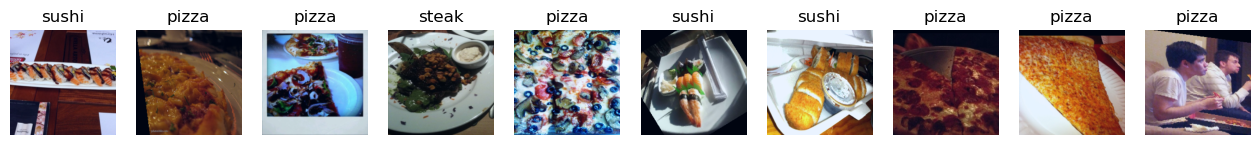

In [51]:
# Check out samples with data augmentationo
view_dataloader_images(train_dataloader_20_percent_with_aug)

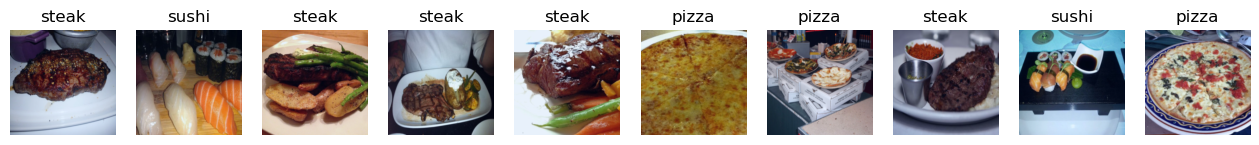

In [52]:
# Checkout data with data augmentation
view_dataloader_images(train_dataloader_20_percent_without_aug)

### Run data aug vs data aug experiments

In [57]:
# Setup number of epochs
epochs = [10, 15]


# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_20_percent_with_aug": train_dataloader_20_percent_with_aug,
                     "data_20_percent_withou_aug": train_dataloader_20_percent_without_aug}


# Create model
models = ['effnetv2_s']

In [58]:
%%time 

# 1. set the random seeds
set_seeds()

# 2. Keep track of experiment number 
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            model = create_model(model_name=model_name) # instantiate a new model instance
            model.to(device)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments 
            train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader_20_percent,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs=epochs,
                 device=device,
                 writer=create_writer(experiment_name=dataloader_name,
                                     model_name=model_name,
                                     extra=f'{epochs}_epochs'))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 5
[INFO] Creating effnetv2_s feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_20_percent_with_aug\effnetv2_s\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9707 | train_acc: 0.5792 | test_loss: 0.7205 | test_acc: 0.8830
Epoch: 2 | train_loss: 0.7283 | train_acc: 0.7896 | test_loss: 0.5496 | test_acc: 0.9136
Epoch: 3 | train_loss: 0.6485 | train_acc: 0.8083 | test_loss: 0.5035 | test_acc: 0.9074
Epoch: 4 | train_loss: 0.5732 | train_acc: 0.8250 | test_loss: 0.4472 | test_acc: 0.9074
Epoch: 5 | train_loss: 0.4809 | train_acc: 0.8750 | test_loss: 0.4231 | test_acc: 0.9165
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_with_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_with_aug
[INFO] Number of epochs: 10
[INFO] Creating effnetv2_s feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_20_percent_with_aug\effnetv2_s\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9951 | train_acc: 0.5417 | test_loss: 0.7160 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7671 | train_acc: 0.7500 | test_loss: 0.6137 | test_acc: 0.8824
Epoch: 3 | train_loss: 0.6255 | train_acc: 0.8604 | test_loss: 0.5421 | test_acc: 0.8852
Epoch: 4 | train_loss: 0.5866 | train_acc: 0.8375 | test_loss: 0.4771 | test_acc: 0.8915
Epoch: 5 | train_loss: 0.5553 | train_acc: 0.8417 | test_loss: 0.4266 | test_acc: 0.8886
Epoch: 6 | train_loss: 0.4884 | train_acc: 0.8458 | test_loss: 0.4092 | test_acc: 0.9097
Epoch: 7 | train_loss: 0.4682 | train_acc: 0.8833 | test_loss: 0.3779 | test_acc: 0.8949
Epoch: 8 | train_loss: 0.4336 | train_acc: 0.8833 | test_loss: 0.3688 | test_acc: 0.9006
Epoch: 9 | train_loss: 0.4518 | train_acc: 0.8542 | test_loss: 0.3685 | test_acc: 0.9074
Epoch: 10 | train_loss: 0.3827 | train_acc: 0.8812 | test_loss: 0.3200 | test_acc: 0.9165
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_with_aug_10_epochs.pth
-------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9775 | train_acc: 0.5667 | test_loss: 0.7409 | test_acc: 0.8063
Epoch: 2 | train_loss: 0.7257 | train_acc: 0.8083 | test_loss: 0.6046 | test_acc: 0.8636
Epoch: 3 | train_loss: 0.6312 | train_acc: 0.7750 | test_loss: 0.5510 | test_acc: 0.8455
Epoch: 4 | train_loss: 0.5053 | train_acc: 0.8938 | test_loss: 0.5011 | test_acc: 0.8580
Epoch: 5 | train_loss: 0.5013 | train_acc: 0.8458 | test_loss: 0.4424 | test_acc: 0.8733
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_withou_aug_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetv2_s
[INFO] DataLoader: data_20_percent_withou_aug
[INFO] Number of epochs: 10
[INFO] Creating effnetv2_s feature extractor model
[INFO] Created SummaryWriter, saving to: runs\2025-07-22\data_20_percent_withou_aug\effnetv2_s\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9546 | train_acc: 0.5813 | test_loss: 0.6932 | test_acc: 0.8705
Epoch: 2 | train_loss: 0.7087 | train_acc: 0.8042 | test_loss: 0.5816 | test_acc: 0.8830
Epoch: 3 | train_loss: 0.6260 | train_acc: 0.8229 | test_loss: 0.5232 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5059 | train_acc: 0.8250 | test_loss: 0.4784 | test_acc: 0.8858
Epoch: 5 | train_loss: 0.4713 | train_acc: 0.8375 | test_loss: 0.4278 | test_acc: 0.8949
Epoch: 6 | train_loss: 0.4891 | train_acc: 0.8063 | test_loss: 0.4199 | test_acc: 0.8915
Epoch: 7 | train_loss: 0.4409 | train_acc: 0.8521 | test_loss: 0.4027 | test_acc: 0.9102
Epoch: 8 | train_loss: 0.4226 | train_acc: 0.8458 | test_loss: 0.3841 | test_acc: 0.9011
Epoch: 9 | train_loss: 0.3950 | train_acc: 0.8771 | test_loss: 0.3618 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.4558 | train_acc: 0.8542 | test_loss: 0.3503 | test_acc: 0.8886
[INFO] Saving model to: models\07_effnetv2_s_data_20_percent_withou_aug_10_epochs.pth
-----------------------

In [61]:
%reload_ext tensorboard
%tensorboard --logdir runs


Reusing TensorBoard on port 6006 (pid 22368), started 1:21:50 ago. (Use '!kill 22368' to kill it.)

Looks Like Effnetv2_s *without* data augmentation performs the best on average for test loss and test accuracy

## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

In [ ]:
# Get Food101 Dataset
import torchvision
train_data = torchvision.datasets.Food101(root='data',
                                         split='train',
                                         download=True)